In [1]:
# Import statements

# Standard Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Model Prep
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV, learning_curve

#Model Types
from sklearn.linear_model import LogisticRegression

#Model Accuracy
from sklearn.metrics import accuracy_score,  log_loss, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, brier_score_loss
from sklearn.calibration import calibration_curve

# Importing for Permutation Importance
from sklearn.inspection import permutation_importance

#For Principal Componenet Analysis (PCA)
from sklearn.decomposition import PCA

#Cross Validating the model
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

#Importing cleaned data
from ipynb.fs.full.ncaabwinsmodel import allgames_df2

C:\Users\txcwa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Dataset Preparation
X = allgames_df2.drop(columns=['Winner'])
y = allgames_df2['Winner']

# Split dataset into training (70%), validation (15%), and test (15%) sets - used for calibation curve
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the features while keeping the DataFrame structure
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Logistic Regression Model Training
log_reg = LogisticRegression(max_iter = 1000000)
log_reg.fit(X_train_scaled, y_train)

# For model evaluation (AIC and BIC discussed at length later in analysis)
n = X_test_scaled.shape[0]  # Number of test data points
log_likelihood = log_reg.score(X_test_scaled, y_test) * n

# Predict probabilities and labels on validation (calibration) and test sets
y_prob_valid = log_reg.predict_proba(X_valid_scaled)[:, 1]
y_prob_test = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_test = log_reg.predict(X_test_scaled)

# Test Set Evaluation
accuracy_log_reg = accuracy_score(y_test, y_pred_test)
print(f"Logistic Regression Accuracy (Test Set): {accuracy_log_reg:.4f}")

Logistic Regression Accuracy (Test Set): 0.7524


Log Loss: 0.4911
Accuracy: 0.7524
Precision: 0.7507
Recall: 0.7475
F1 Score: 0.7491
ROC-AUC Score: 0.8391
Best Threshold by Youden’s J statistic: 0.4812


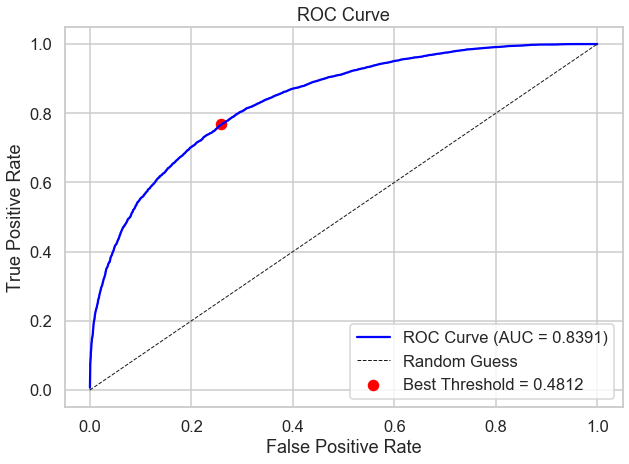

In [3]:
# Classification Specific Evaluation Metrics 
# https://en.wikipedia.org/wiki/Precision_and_recall

# Calculate log loss
logloss = log_loss(y_test, y_prob_test)
print(f'Log Loss: {logloss:.4f}')

# Calculate classification-specific metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.4f}') # Correct predictions/Total Predictions
print(f'Precision: {precision:.4f}') # True positives/Total Oberservations
print(f'Recall: {recall:.4f}') # True positives/ Predicted Positives
print(f'F1 Score: {f1:.4f}') # Harmonic Mean of Precision and Recall

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)

# Calculate the Youden's J statistic for each threshold, In this case looking for max of 
# True postive rate compared to False postiive rate (TPR - FPR), 
# Unfortunately because this a W/L model the threshold has to be .5
j_scores = tpr - fpr
best_threshold_index = j_scores.argmax()
best_threshold = thresholds[best_threshold_index]
print(f'Best Threshold by Youden’s J statistic: {best_threshold:.4f}')

# Set Seaborn style and context for the plot
sns.set(style="whitegrid", context="talk")

# Plot ROC Curve using Seaborn for styling
plt.figure(figsize=(10, 7))
sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)  # Diagonal line for random guess
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', marker='o',
            s=100, label=f'Best Threshold = {best_threshold:.4f}')

# Enhance plot aesthetics with Seaborn
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

# Show the plot
plt.show()

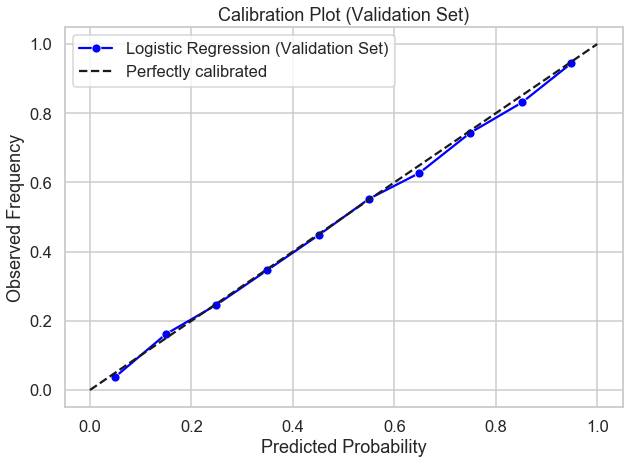

Brier Score: 0.1638
Expected Calibration Error (ECE): 0.0093


In [4]:
# Calibration Curve: Generated from validation (calibration) set
prob_true, prob_pred = calibration_curve(y_valid, y_prob_valid, n_bins=10)

# Set Seaborn style and context for the plot
sns.set(style="whitegrid", context="talk")

# Create the calibration plot with Seaborn styling
plt.figure(figsize=(10, 7))
sns.lineplot(x=prob_pred, y=prob_true, marker='o', color='blue', label='Logistic Regression (Validation Set)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')  # Reference line for perfect calibration

# Add labels and title
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Plot (Validation Set)')
plt.legend(loc='best')

# Show the plot
plt.show()

# Probability Evaluation techniques
# Brier Score and Expected Calibration Error

# https://towardsdatascience.com/expected-calibration-error-ece-a-step-by-step-visual-explanation-with-python-code-c3e9aa12937d

# Brier Score: type of cost function which is a sum of squared differences. measure the average distance between the 
# predicted probability and the actual outcome
brier_score = brier_score_loss(y_test, y_prob_test)
print(f"Brier Score: {brier_score:.4f}")

# Expected Calibration Error (ECE): works really well with calibration plot and they are sanity checks against each other, 
# should always be in agreement

#ECE: Measures the calibration of a model. When a model guesses with 70% probability that an observation should be in the
# positive class, ECE measure that for the total amount of guesses in the 70% range the model is correct 70% of the time
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_mask = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i + 1])
        bin_size = np.sum(bin_mask)
        if bin_size > 0:
            bin_accuracy = np.mean(y_true[bin_mask])
            bin_confidence = np.mean(y_prob[bin_mask])
            ece += (bin_size / len(y_prob)) * abs(bin_confidence - bin_accuracy)
    return ece

ece = expected_calibration_error(y_test, y_prob_test)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

Explained Variance Ratio for PC1: 0.3305
Explained Variance Ratio for PC2: 0.0829
Total Explained Variance by PC1 and PC2: 0.4134


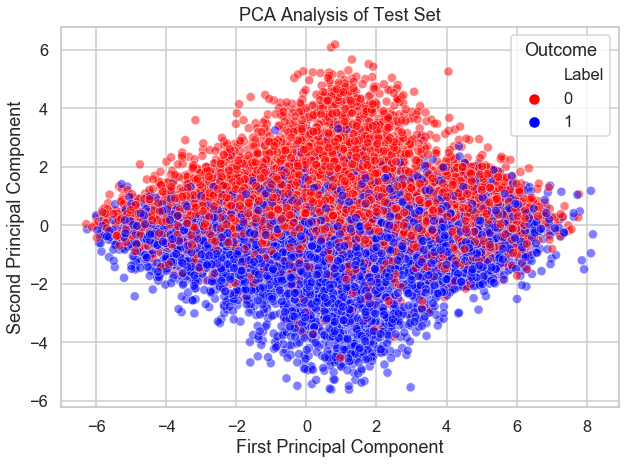

In [5]:
# Perform PCA on the test set for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

print(f'Explained Variance Ratio for PC1: {explained_variance_ratio[0]:.4f}')
print(f'Explained Variance Ratio for PC2: {explained_variance_ratio[1]:.4f}')
print(f'Total Explained Variance by PC1 and PC2: {explained_variance_ratio.sum():.4f}')

# Set Seaborn style
sns.set(style="whitegrid", context="talk")

# Convert PCA results to a DataFrame for use with Seaborn
pca_df = pd.DataFrame({
    'PC1': X_test_pca[:, 0],
    'PC2': X_test_pca[:, 1],
    'Label': y_test  # This should be appropriately mapped to categorical labels if needed
})

# Plot the first two principal components with Seaborn's scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Label', 
    palette={0: 'red', 1: 'blue'}, 
    data=pca_df, 
    alpha=0.5
)

# Add labels and title
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Analysis of Test Set')
plt.legend(title='Outcome', loc='best')

# Show the plot
plt.show()

In [6]:
# Calculate regression-specific metrics on predicted probabilities
mae = mean_absolute_error(y_test, y_prob_test)
mse = mean_squared_error(y_test, y_prob_test)
rmse = np.sqrt(mse)

# R-squared and Adjusted R-squared calculations
r_squared = r2_score(y_test, y_prob_test)
n = len(y_test)  # Number of samples
p = X_test.shape[1]  # Number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Print regression metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-Squared: {r_squared:.4f}")
print(f"Adjusted R-Squared: {adjusted_r_squared:.4f}")


Mean Absolute Error (MAE): 0.3280
Mean Squared Error (MSE): 0.1638
Root Mean Squared Error (RMSE): 0.4047
R-Squared: 0.3449
Adjusted R-Squared: 0.3440


In [7]:
#Cross Validation

# Set up K-Fold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform K-Fold Cross-Validation
cv_scores = cross_val_score(log_reg, X, y, cv=kf, scoring='accuracy')

# Print the average accuracy and standard deviation
print(f'K-Fold Cross-Validation Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')

K-Fold Cross-Validation Accuracy: 0.7504 ± 0.0012


Specificity: 0.7573


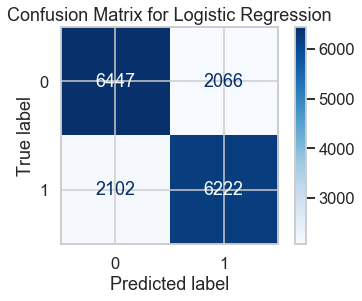

In [8]:
# Confusion Matrix and Specificity

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()  # Unpack confusion matrix values

# Calculate specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()


In [9]:
# Model Complexity and Regularization (Overfitting Prevention)

# Akaike Information Criterion: penalizes overfitting and is only used in comparison to other models
# Bayesian Information Criterion: Has a bigger penalty term, both AIC and BIC are trying to penalize overfitting by the
# addition of more parameters to the model 

# Calculate AIC and BIC
n = X_test.shape[0]  # Number of data points
k = X_test.shape[1]  # Number of features

# Log-likelihood

aic = (2 * k) - (2 * log_likelihood) # Measure of information loss in the model
bic = (np.log(n) * k) - (2 * log_likelihood)

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

# L1 (Lasso) and L2 (Ridge) Regularization
# L1 (Lasso): Used to opitimize OLS to eliminate Colinearity and redundancy 
# L2 (Ridge): Focuses on limiting colinearity 

# Set up the parameter grid for L1 and L2
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-1, 1, 5)  # Range of C values from .1 to 10
}

# Grid search with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_accuracy:.4f}")

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model on the test set
accuracy_test = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy_test:.4f}")
print("Classification Report:")
print(report)

# Retrieve the penalty and coefficients of the best model
penalty = best_model.penalty
coefficients = best_model.coef_

if penalty == 'l1':
    penalty_value = np.sum(np.abs(coefficients))
else:
    penalty_value = np.sum(coefficients** 2)

print(f"Best Model Penalty: {penalty}")
print(f"Best Penalty Value:{penalty_value}")
# print(f"Best Model Coefficients: {coefficients}")

AIC: -25292.00
BIC: -25114.18


C:\Users\txcwa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\txcwa\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\txcwa\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\txcwa\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    % (solver, penalty)
Va

Best Parameters: {'C': 1.0, 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.7500
Test Set Accuracy: 0.7534
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      8513
           1       0.75      0.75      0.75      8324

    accuracy                           0.75     16837
   macro avg       0.75      0.75      0.75     16837
weighted avg       0.75      0.75      0.75     16837

Best Model Penalty: l2
Best Penalty Value:0.06517425323632446


In [10]:
# Interpretability and Feature Analysis

# Permutation Feature Importance: measures how the accuracy changes when the values of a feature are shuffled
results = permutation_importance(log_reg, X_test, y_test, n_repeats=30, random_state=42)

# Create a DataFrame for better visualization
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': results.importances_mean,
    'Std': results.importances_std
}).sort_values(by='Importance', ascending=False)

print("Permutation Feature Importance:")
print(perm_importance_df)

Permutation Feature Importance:
          Feature  Importance       Std
3          AdjO_A    0.063281  0.002006
14         AdjO_B    0.054481  0.001992
4          AdjD_A    0.041551  0.002112
15         AdjD_B    0.034430  0.002022
17    AdjEM_SOS_B    0.008343  0.001301
21         Seed_B    0.005920  0.000969
10         Seed_A    0.005563  0.001181
7          OppO_A    0.003288  0.001161
8          OppD_A    0.002692  0.000963
6     AdjEM_SOS_A    0.001194  0.001555
1        TeamID_A    0.001182  0.000732
12       TeamID_B    0.000938  0.001204
11    Conf_Tier_A    0.000337  0.000266
19         OppD_B    0.000325  0.000764
2          Conf_A    0.000044  0.000456
5          AdjT_A    0.000034  0.000114
0          Season   -0.000034  0.000059
16         AdjT_B   -0.000061  0.000232
13         Conf_B   -0.000071  0.000658
18         OppO_B   -0.000077  0.000920
22    Conf_Tier_B   -0.000111  0.000273
9   AdjEM_NCSOS_A   -0.000295  0.000310
20  AdjEM_NCSOS_B   -0.000632  0.000277


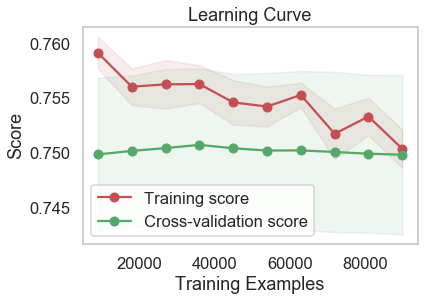

In [11]:
# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=log_reg,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy'
)

# Calculate mean and standard deviation for plotting
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.grid()

# Plot the training scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')

# Plot the cross-validation scores
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()


Logistic Regression
Without Luck, AdjEM, First and Last D1 Season:
K-Fold Cross-Validation Accuracy: 0.7504 ± 0.0012
Log Loss: 0.4911
Accuracy: 0.7524
Precision: 0.7507
Recall: 0.7475
F1 Score: 0.7491
ROC-AUC Score: 0.8391
Best Threshold by Youden’s J statistic: 0.4812
Expected Calibration Error (ECE): 0.0093

Neural Network
Log Loss: 0.5052
Accuracy: 0.7449
Precision: 0.7471
Recall: 0.7339
F1 Score: 0.7404
ROC-AUC Score: 0.8288
Best Threshold by Youden’s J statistic: 0.4831
Expected Calibration Error (ECE) for MLP Classifier: 0.0646

Random Forest
Mean cross-validation accuracy:  0.7094607593478615
Log Loss: 0.5820
Accuracy: 0.7118
Precision: 0.7097
Recall: 0.7139
F1 Score: 0.7118
ROC-AUC Score: 0.7786
Best Threshold by Youden’s J statistic: 0.4867

XGBooster
Log Loss: 0.5164
Accuracy: 0.7372
Precision: 0.7344
Recall: 0.7361
F1 Score: 0.7353
ROC-AUC Score: 0.8211
Best Threshold by Youden’s J statistic: 0.4742
Expected Calibration Error (ECE) for XGB Classifier: 0.0344